In [2]:
import gymnasium as gym
import numpy as np
import os, sys
import time
import sys
import traffic_control_game
import pygame
import random
import itertools
import matplotlib.pyplot as plt

In [71]:
class QLearningAgent:
    def __init__(self, params, n_episodes, n_actions):
        self.params = params
        self.n_episodes = n_episodes
        self.n_actions = n_actions
        for key in params:
            setattr(self, key, params[key])

        self.action_space = np.array(range(self.n_actions))
        self.init_epsilon = params["epsilon"]


        if self.epsilon_decay:
            self.epsilon_decay_factor = (0.001/self.init_epsilon)**(1/n_episodes)
            self.epsilon_decay_increment = self.init_epsilon/n_episodes

        poss_states = list(itertools.product([_ for _ in range(25)], [_ for _ in range(25)], [_ for _ in range(25)], [_ for _ in range(25)]))
        self.Q = {tuple(coordinates): [0]*self.n_actions for coordinates in poss_states}
        self.N = {tuple(coordinates): 0 for coordinates in poss_states}
        self.history = {
            "scores": np.zeros(n_episodes),
            "epsilon" : np.zeros(n_episodes),
            "chosen_actions": [0]*self.n_actions
        }


    def random_action(self):
        rand_action = np.random.choice(self.action_space)
        return rand_action

    def get_state_tuple(self, obs):
        return (obs["north"], obs["east"], obs["south"],obs["west"])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.RandomState().choice(ties)

    
    def update_history(self, episode, score, epsilon):
        self.history["scores"][episode] = score
        self.history["epsilon"][episode] = epsilon

    def get_action(self, obs):
        """
        Choose action epsilon-greedily.
        
        obs: (dx, dy) to nearest pipe

        """
        state = self.get_state_tuple(obs)

        if random.random() < self.epsilon:
            return self.random_action()

        return self.argmax(self.Q[state])
    
    def update(self, obs, next_obs, action, reward, done):
        state, next_state  = self.get_state_tuple(obs), self.get_state_tuple(next_obs)

        self.N[state] += 1
        self.Q[state][action] += self.step_size * (reward + self.gamma*np.amax(self.Q[next_state]) - self.Q[state][action])


    def update_epsilon(self):
        if self.epsilon_decay == "linear":
            self.epsilon -= self.epsilon_decay_increment
        elif self.epsilon_decay == "exponential":
            self.epsilon *= self.epsilon_decay_factor

    def ratio_states_visited(self):
        visited = [1 if n_visits != 0 else 0 for state, n_visits in self.N.items()]
        return sum(visited)/len(visited)
    
    def train(self, n_episodes):
        env = gym.make("traffic_control-v0", n_actions = self.n_actions, render_mode=None) 
        best_score = 0
        for episode in range(n_episodes):
            obs, info = env.reset()
            while True:
                # Select next action
                action = self.get_action(obs)   # for an agent, action = agent.policy(observation)
                # Appy action and return new observation of the environment
                next_obs, reward, done, _, info = env.step(action)

                self.update(obs, next_obs, action, reward, done)
                self.history["chosen_actions"][action] += 1
                obs = next_obs

                env.render()

                if done:
                    break
                
            self.update_epsilon()
            

            score = info["score"]
            self.update_history(episode, score, self.epsilon)
            best_score = score if score > best_score else best_score
            if (episode + 1) % 50 == 0:
                print(f"Episode {episode + 1}/{n_episodes} *** Best score: {best_score} *** States visited: {self.ratio_states_visited()*100: .2f}%")

        env.close()

In [72]:
def plot_results(agent):
    scores = agent.history["scores"]
    epsilons = agent.history["epsilon"]
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    fig.suptitle(f"QLearning agent")
    ax[0].plot(scores, "b")
    ax[0].set_xlabel("Episodes")
    ax[0].set_title(f"Score (best: {max(scores): .0f})")
    ax[1].plot(epsilons, "b")
    ax[1].set_xlabel("Episodes")
    ax[1].set_title(f"Epsilon (final value: {epsilons[-1]: .1e})")
    fig.tight_layout()

In [73]:
N_EPISODES = 1000
params = {
    "epsilon": 0.2,
    "epsilon_decay": "linear",
    "step_size": 0.1,
    "gamma": 1
}
agent = QLearningAgent(params, N_EPISODES, n_actions = 4)

In [74]:
agent.train(N_EPISODES)

Episode 50/1000 *** Best score: 7 *** States visited:  0.02%
Episode 100/1000 *** Best score: 9 *** States visited:  0.04%
Episode 150/1000 *** Best score: 12 *** States visited:  0.06%
Episode 200/1000 *** Best score: 17 *** States visited:  0.09%
Episode 250/1000 *** Best score: 17 *** States visited:  0.10%
Episode 300/1000 *** Best score: 19 *** States visited:  0.13%
Episode 350/1000 *** Best score: 19 *** States visited:  0.15%
Episode 400/1000 *** Best score: 19 *** States visited:  0.17%
Episode 450/1000 *** Best score: 19 *** States visited:  0.18%
Episode 500/1000 *** Best score: 23 *** States visited:  0.20%
Episode 550/1000 *** Best score: 23 *** States visited:  0.22%
Episode 600/1000 *** Best score: 23 *** States visited:  0.23%
Episode 650/1000 *** Best score: 25 *** States visited:  0.26%
Episode 700/1000 *** Best score: 25 *** States visited:  0.28%
Episode 750/1000 *** Best score: 42 *** States visited:  0.30%
Episode 800/1000 *** Best score: 47 *** States visited:  0

In [14]:
env = gym.make("traffic_control-v0", num_actions = 4) 
best_score = 0
for episode in range(N_EPISODES):
    obs, info = env.reset()
    while True:
        # Select next action
        action = agent.get_action(obs)   # for an agent, action = agent.policy(observation)
        
        # Appy action and return new observation of the environment
        next_obs, reward, done, _, info = env.step(action)

        agent.update(obs, next_obs, action, reward, done)
        obs = next_obs

        env.render()

        if done:
            break
        
    agent.update_epsilon()
    

    score = info["score"]
    agent.update_history(episode, score, agent.epsilon)
    best_score = score if score > best_score else best_score
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}/{N_EPISODES} *** Best score:", best_score)
        

env.close()

Episode 50/10000 *** Best score: 5
Episode 100/10000 *** Best score: 14
Episode 150/10000 *** Best score: 19
Episode 200/10000 *** Best score: 19
Episode 250/10000 *** Best score: 22
Episode 300/10000 *** Best score: 23
Episode 350/10000 *** Best score: 23
Episode 400/10000 *** Best score: 25
Episode 450/10000 *** Best score: 25
Episode 500/10000 *** Best score: 25
Episode 550/10000 *** Best score: 25
Episode 600/10000 *** Best score: 25
Episode 650/10000 *** Best score: 25
Episode 700/10000 *** Best score: 25
Episode 750/10000 *** Best score: 25
Episode 800/10000 *** Best score: 26
Episode 850/10000 *** Best score: 26
Episode 900/10000 *** Best score: 30
Episode 950/10000 *** Best score: 30
Episode 1000/10000 *** Best score: 30
Episode 1050/10000 *** Best score: 30
Episode 1100/10000 *** Best score: 31
Episode 1150/10000 *** Best score: 31
Episode 1200/10000 *** Best score: 32
Episode 1250/10000 *** Best score: 32
Episode 1300/10000 *** Best score: 32
Episode 1350/10000 *** Best score

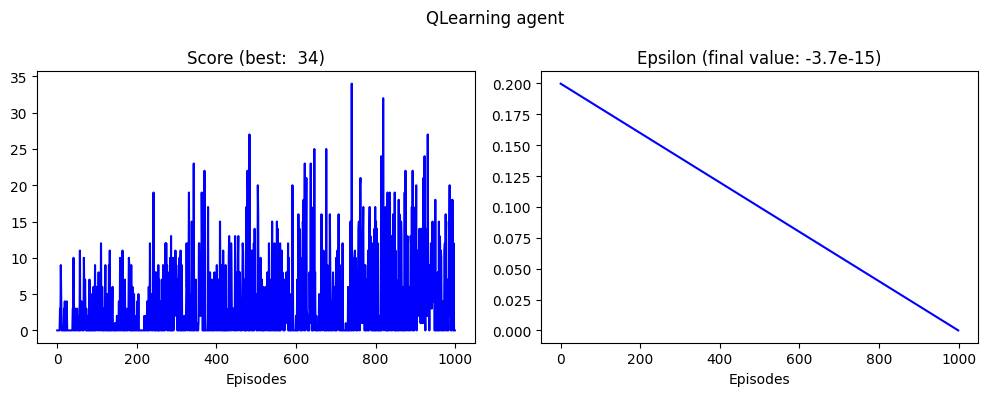

In [49]:
plot_results(agent)

In [50]:
agent.history["chosen_actions"]

[5846, 6335, 13263, 2135]

In [20]:
import json
q = agent.Q.copy()
key_value = list(q.items())
for key, val in key_value:
    q[str(key)] = val
    q.pop(key)
n = agent.N.copy()
key_value = list(n.items())
for key, val in key_value:
    n[str(key)] = val
    n.pop(key)
res = {
    "scores" : list(agent.history["scores"]),
    "epsilon" : list(agent.history["epsilon"]),
    "Q" : q,
    "N": n
}
filename = "run1"

with open("./results/QLearning/" + filename + ".json", "w") as f:
    json.dump(res, f)